Epoch   0 / iter   0, loss = 7.0961
Epoch   0 / iter   1, loss = 0.6654
Epoch   0 / iter   2, loss = 0.3429
Epoch   0 / iter   3, loss = 0.4864
Epoch   0 / iter   4, loss = 0.6278
Epoch   1 / iter   0, loss = 0.6507
Epoch   1 / iter   1, loss = 0.9969
Epoch   1 / iter   2, loss = 1.5353
Epoch   1 / iter   3, loss = 2.4381
Epoch   1 / iter   4, loss = 1.5588
Epoch   2 / iter   0, loss = 2.6289
Epoch   2 / iter   1, loss = 0.3820
Epoch   2 / iter   2, loss = 0.3189
Epoch   2 / iter   3, loss = 0.3115
Epoch   2 / iter   4, loss = 0.3770
Epoch   3 / iter   0, loss = 0.4648
Epoch   3 / iter   1, loss = 1.0960
Epoch   3 / iter   2, loss = 1.7831
Epoch   3 / iter   3, loss = 2.3209
Epoch   3 / iter   4, loss = 1.9400
Epoch   4 / iter   0, loss = 2.4583
Epoch   4 / iter   1, loss = 1.7921
Epoch   4 / iter   2, loss = 1.2824
Epoch   4 / iter   3, loss = 0.4456
Epoch   4 / iter   4, loss = 0.2668
Epoch   5 / iter   0, loss = 0.2010
Epoch   5 / iter   1, loss = 0.0806
Epoch   5 / iter   2, loss =

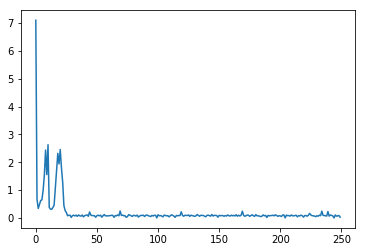

In [12]:
import numpy as np
import json
import matplotlib.pyplot as plt



def load_data():
    # 从文件导入数据
    datafile = './data/housing.data'
    data = np.fromfile(datafile, sep=' ')

    # 每条数据包括14项，其中前面13项是影响因素，第14项是相应的房屋价格中位数
    feature_names = [ 'CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE',                       'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV' ]
    feature_num = len(feature_names)

    # 将原始数据进行Reshape，变成[N, 14]这样的形状
    data = data.reshape([data.shape[0] // feature_num, feature_num])

    # 将原数据集拆分成训练集和测试集
    # 这里使用80%的数据做训练，20%的数据做测试
    # 测试集和训练集必须是没有交集的
    ratio = 0.8
    offset = int(data.shape[0] * ratio)
    training_data = data[:offset]

    # 计算训练集的最大值，最小值，平均值
    maximums, minimums, avgs = training_data.max(axis=0), training_data.min(axis=0),                                  training_data.sum(axis=0) / training_data.shape[0]

    global max_values
    global min_values
    global avg_values
    max_values=maximums
    min_values=minimums
    avg_values=avgs

    # 对数据进行归一化处理
    for i in range(feature_num):
        #print(maximums[i], minimums[i], avgs[i])
        data[:, i] = (data[:, i] - minimums[i]) / (maximums[i] - minimums[i])

    # 训练集和测试集的划分比例
    training_data = data[:offset]
    test_data = data[offset:]
    return training_data, test_data


# 定义隐藏层使用的激活函数
def Sigmoid(x):
    return 1/(1+np.exp(-x))


# 创建一个两层神经网络的类

class Network(object):
    def __init__(self, num_of_weights):
        # 随机产生w的初始值
        # 为了保持程序每次运行结果的一致性，此处设置固定的随机数种子
        np.random.seed(321)
        #初始化参数
        self.w1 = np.random.randn(num_of_weights, 128)
        self.b1 = 0.
        self.w2=np.random.randn(128,1)
        self.b2=0.

    def forward(self, x):
        #正向传播
        z1 = np.dot(x, self.w1) + self.b1
        o1=Sigmoid(z1)
        o2= np.dot(o1,self.w2)+self.b2
        return z1,o1,o2

    #计算损失
    def loss(self, z, y):
        error = z - y
        num_samples = error.shape[0]
        cost = error * error
        cost = np.sum(cost) / num_samples
        return cost

    def gradient(self, x, y, z1,o1,o2):

        #此处略复杂，经过手工计算梯度反向传播公式，然后分别计算相应的梯度
        N = o1.shape[0]
        gradient_w2 = 1. / N * np.sum((o2-y) * o1, axis=0)
        gradient_w2 = gradient_w2[:, np.newaxis]
        gradient_b2 = 1. / N * np.sum(o2-y)

        M=x.shape[0]
        gradient_w1=1. /M*np.sum(np.dot(self.w2.T,np.dot(o1.T,(o2-y)))*np.dot(x.T,(1-o1)),axis=0)
        gradient_w1 = gradient_w1[:, np.newaxis]
        gradient_b1=1. /M*np.sum(np.dot(self.w2.T,np.dot(o1.T,(o2-y)))*(1-o1),axis=0)

        return gradient_w1, gradient_b1,gradient_w2, gradient_b2

    #根据计算出的梯度分别对两层的参数进行更新
    def update(self, gradient_w1, gradient_b1, gradient_w2, gradient_b2, eta = 0.01):
        self.w2 = self.w2 - eta * gradient_w2
        self.b2 = self.b2 - eta * gradient_b2
        self.w1 = self.w1 - eta * gradient_w1.T
        self.b1 = self.b1 - eta * gradient_b1

    # 训练过程
    def train(self, training_data, num_epochs, batch_size=10, eta=0.01):
        n = len(training_data)
        losses = []
        for epoch_id in range(num_epochs):
            # 在每轮迭代开始之前，将训练数据的顺序随机打乱
            # 然后再按每次取batch_size条数据的方式取出
            np.random.shuffle(training_data)
            # 将训练数据进行拆分，每个mini_batch包含batch_size条的数据
            mini_batches = [training_data[k:k+batch_size] for k in range(0, n, batch_size)]
            for iter_id, mini_batch in enumerate(mini_batches):
                #print(self.w.shape)
                #print(self.b)
                x = mini_batch[:, :-1]
                y = mini_batch[:, -1:]
                z1,o1,o2 = self.forward(x)
                loss = self.loss(o2, y)
                gradient_w1, gradient_b1, gradient_w2, gradient_b2= self.gradient(x, y, z1,o1,o2)
                self.update(gradient_w1, gradient_b1, gradient_w2, gradient_b2, eta)
                losses.append(loss)
                print('Epoch {:3d} / iter {:3d}, loss = {:.4f}'.
                                 format(epoch_id, iter_id, loss))

        return losses


train_data, test_data = load_data()

# 创建网络
net = Network(13)
# 启动训练
losses = net.train(train_data, num_epochs=50, batch_size=100, eta=0.001)

# 画出损失函数的变化趋势
plot_x = np.arange(len(losses))
plot_y = np.array(losses)
plt.plot(plot_x, plot_y)
plt.show()



def load_one_example():
    # 从上边已加载的测试集中，随机选择一条作为测试数据
    idx = np.random.randint(0, test_data.shape[0])
    one_data, label = test_data[idx, :-1], test_data[idx, -1]
    # 修改该条数据shape为[1,13]
    one_data =  one_data.reshape([1,-1])

    return one_data, label



one_data, label = load_one_example()
_, _, predict=net.forward(one_data)

# 对结果做反归一化处理
predict = predict * (max_values[-1] - min_values[-1]) + avg_values[-1]
# 对label数据做反归一化处理
label = label * (max_values[-1] - min_values[-1]) + avg_values[-1]

print("Inference result is {}, the corresponding label is {}".format(predict, label))